In [8]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import ezc3d
import os

from Functions import Joint_Angle
from Functions import Animated

def calculate_angle_between_vectors(vec1, vec2):
    # 내적과 벡터 크기를 이용하여 cos(theta) 계산
    dot_product = np.dot(vec1, vec2)
    magnitude_1 = np.linalg.norm(vec1)
    magnitude_2 = np.linalg.norm(vec2)
    cos_theta = dot_product / (magnitude_1 * magnitude_2)

    # cos(theta)를 이용하여 각도(라디안) 계산
    angle_radians = np.arccos(cos_theta)

    # 라디안을 도로 변환
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

def R_UpperArm(RSHO, RUPA, RELB, RSJC, REJC):
    origin = RSJC
    z = RSJC - REJC
    x_temp = RELB - REJC
    y = np.cross(z, x_temp)
    x = np.cross(y, z)
    
    x_norm = x/np.linalg.norm(x)
    y_norm = y/np.linalg.norm(y)
    z_norm = z/np.linalg.norm(z)
    
    R = np.transpose(np.array([x_norm,y_norm,z_norm]))
    T = np.array([[R[0,0],R[0,1],R[0,2],origin[0]],
                  [R[1,0],R[1,1],R[1,2],origin[1]],
                  [R[2,0],R[2,1],R[2,2],origin[2]],
                  [0     ,0     ,0     ,1    ]])
    return T

def Trunk(C7, T10, CLAV, STRN):
    origin = (C7 + CLAV)/2
    prox = (T10 + STRN) / 2
    z = origin - prox
    y_temp = CLAV - C7
    x = np.cross(z, y_temp)
    y = np.cross(z, x)
    
    x_norm = x/np.linalg.norm(x)
    y_norm = y/np.linalg.norm(y)
    z_norm = z/np.linalg.norm(z)
    
    R = np.transpose(np.array([x_norm,y_norm,z_norm]))
    T = np.array([[R[0,0],R[0,1],R[0,2],origin[0]],
                  [R[1,0],R[1,1],R[1,2],origin[1]],
                  [R[2,0],R[2,1],R[2,2],origin[2]],
                  [0     ,0     ,0     ,1    ]])
    return T

import sys
from Functions import Animated
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from Functions import Animated


speed = 1
name = ''
axis = 'z'

In [9]:
file_list = [i.replace('\\','/') for i in sorted(glob('Data/vicon_c3d/**/*c3d'))]
file_name = [os.path.basename(i).replace('.c3d','') for i in file_list]
AB_list = [i for i in file_list if "AB" in i]
AB_name = [os.path.basename(i).replace('.c3d','') for i in AB_list]
FL_list = [i for i in file_list if "FL" in i]
FL_name = [os.path.basename(i).replace('.c3d','') for i in FL_list]
YB_list = [i for i in file_list if "Y-BAL" in i]
YB_name = [os.path.basename(i).replace('.c3d','') for i in YB_list]
Other_list = [i for i in file_list if ("HAD" in i)|("IRER" in i)]
Other_name = [os.path.basename(i).replace('.c3d','') for i in Other_list]

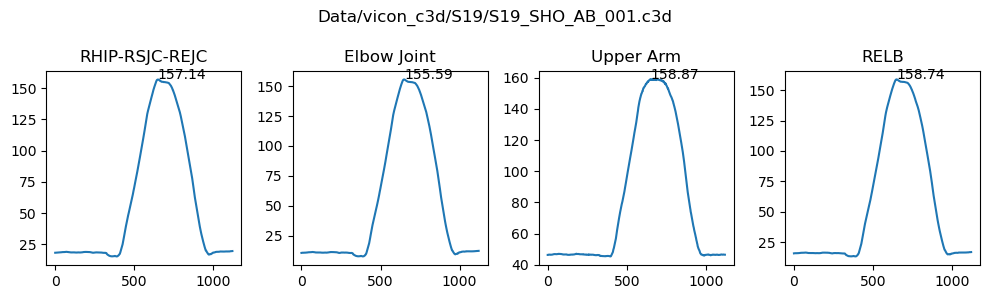

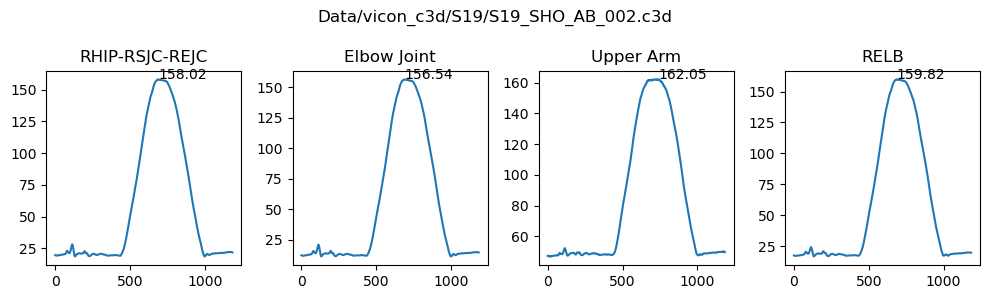

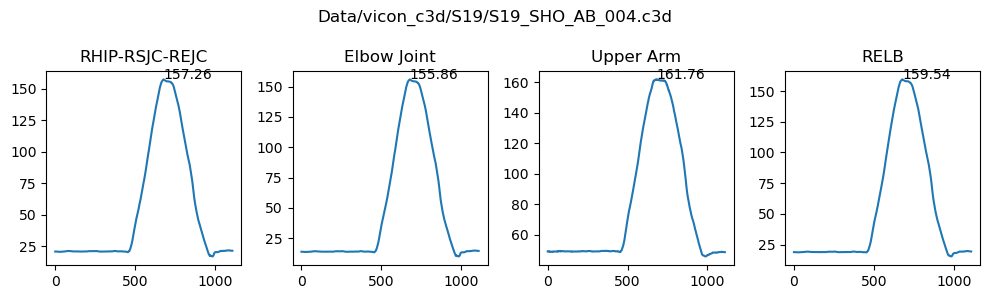

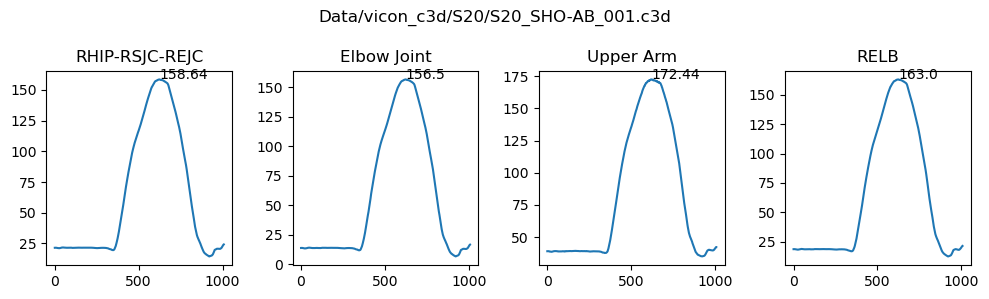

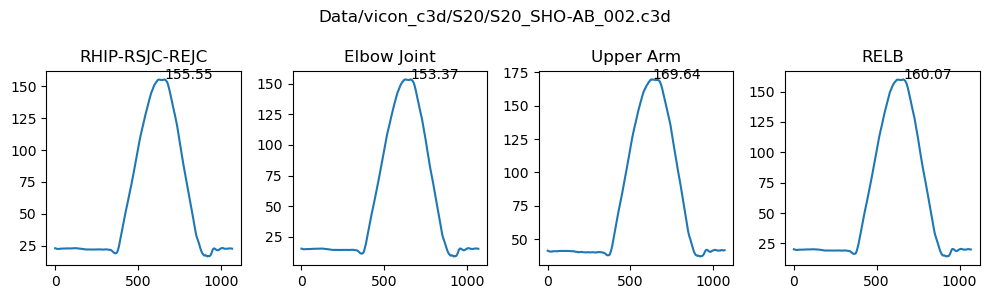

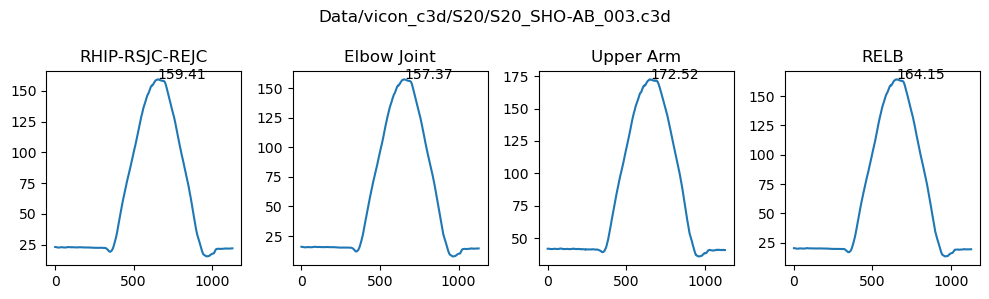

In [10]:
max_angle = []
max_angle1 = [] 
max_angle2 = []
max_angle3 = []
for file in AB_list:
    c3d = ezc3d.c3d(file)
    markers = {}
    N = len(c3d['parameters']['POINT']['LABELS']['value'])

    for i in range(N):
        markers[c3d['parameters']['POINT']['LABELS']['value'][i]] = c3d['data']['points'][:3,i,:]

    markers['PELVIS'] = (markers['RHJC']+markers['LHJC'])/2
    markers['Dist'] = (markers['CLAV']+markers['C7'])/2
    markers['Prox'] = (markers['STRN']+markers['T10'])/2
    
    marker_df = pd.DataFrame()
    marker = {}

    for c in ['RHJC','RSJC','REJC','RUPA','RSHO','Dist','Prox','LHJC','LSJC','LUPA','LEJC','LSHO','PELVIS','RELB']:
        marker[c] = markers[c]
        mkr = pd.DataFrame(markers[c])
        marker_df= pd.concat([marker_df,mkr])
        
    RHIP = marker['RHJC'][[0,2],:]
    RSJC = marker['RSJC'][[0,2],:]
    REJC = marker['REJC'][[0,2],:]
    RUPA = marker['RUPA'][[0,2],:]
    PELVIS = marker['PELVIS'][[0,2], :]
    THORAX = marker['Dist'][[0,2], :]
    RELB = marker['RELB'][[0,2],:]
    line = RHIP - RSJC
    line1 = PELVIS - THORAX
    line2 = REJC - RSJC
    line3 = RUPA - RSJC
    line4 = RELB - RSJC
    
    # 두 벡터 사이의 각도 계산
    N = line1.shape[-1]
    angles = np.zeros(N)
    angles1 = np.zeros(N)
    angles2 = np.zeros(N)
    angles3 = np.zeros(N)
    for i in range(N):
        angles[i] = calculate_angle_between_vectors(line[:,i], line2[:,i])
        angles1[i] = calculate_angle_between_vectors(line1[:,i], line2[:,i])
        angles2[i] = calculate_angle_between_vectors(line1[:,i], line3[:,i])
        angles3[i] = calculate_angle_between_vectors(line1[:,i], line4[:,i])
        
    fig, ax = plt.subplots(1,4, figsize=(10,3))
    max_angle.append(np.nanmax(angles))
    max_angle1.append(np.nanmax(angles1))
    max_angle2.append(np.nanmax(angles2))
    max_angle3.append(np.nanmax(angles3))
    
    ax[0].plot(angles)
    ax[0].text(x=np.where(angles == np.nanmax(angles))[0][0], y = np.nanmax(angles), s = round(np.nanmax(angles),2))
    ax[0].set_title('RHIP-RSJC-REJC')
    ax[1].plot(angles1)
    ax[1].text(x=np.where(angles1 == np.nanmax(angles1))[0][0], y = np.nanmax(angles1), s = round(np.nanmax(angles1),2))
    ax[1].set_title('Elbow Joint')
    ax[2].plot(angles2)
    ax[2].text(x=np.where(angles2 == np.nanmax(angles2))[0][0], y = np.nanmax(angles2), s = round(np.nanmax(angles2),2))
    ax[2].set_title('Upper Arm')
    ax[3].plot(angles3)
    ax[3].text(x=np.where(angles3 == np.nanmax(angles3))[0][0], y = np.nanmax(angles3), s = round(np.nanmax(angles3),2))
    ax[3].set_title('RELB')
    plt.suptitle(file)
    plt.tight_layout()
    plt.show()
    connections = [
    ('RHJC', 'RSJC'),('RSJC','RUPA'),('REJC','RUPA'),('REJC','RSJC'),
    ('LHJC', 'LSJC'),('LSJC','LUPA'),('LEJC','LUPA'),('LEJC','LSJC'),
    ('RHJC','LHJC'),('RSJC','RELB'),
    ('PELVIS','Dist'),
    # ('T10','C7'),
    # ('T10','STRN'),('T10','CLAV'), ('C7','STRN'),('CLAV','C7'),
]
    anim = Animated.Animate_3d(marker,speed,270,axis,file,60,connections)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

In [14]:
print(f"RHJC-RSJC-REJC    : {np.mean(max_angle):.2f} ± {np.std(max_angle):.2f}")
print(f"Elbow joint       : {np.mean(max_angle1):.2f} ± {np.std(max_angle1):.2f}")
print(f"Upper Arm Marker  : {np.mean(max_angle2):.2f} ± {np.std(max_angle2):.2f}")
print(f"Elbow Marker      : {np.mean(max_angle3):.2f} ± {np.std(max_angle3):.2f}")

RHJC-RSJC-REJC    : 157.67 ± 1.22
Elbow joint       : 155.87 ± 1.25
Upper Arm Marker  : 166.21 ± 5.50
Elbow Marker      : 160.89 ± 1.97


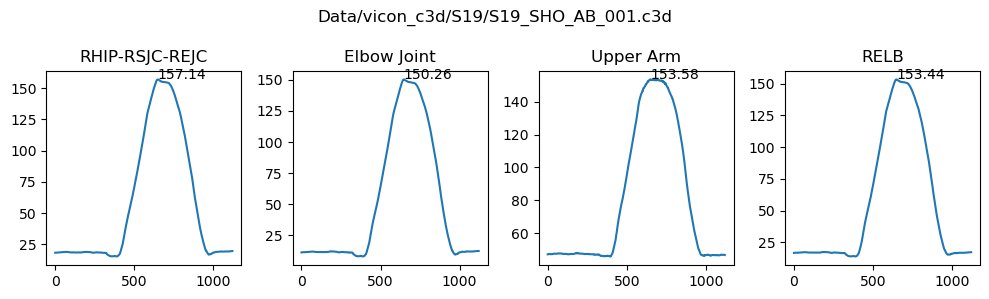

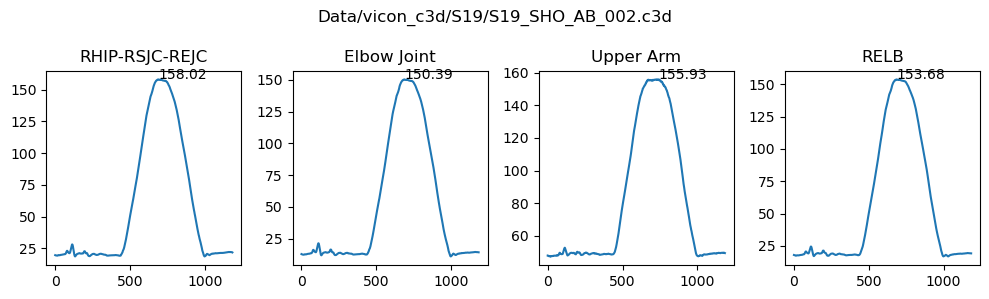

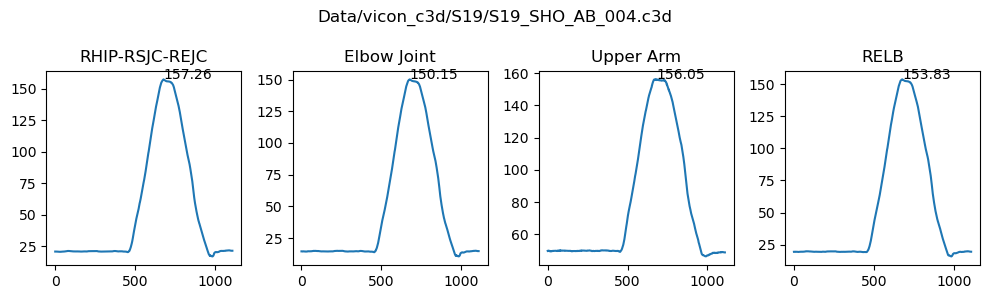

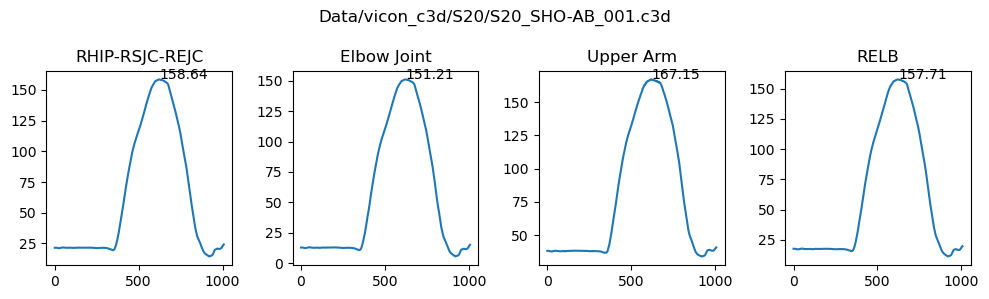

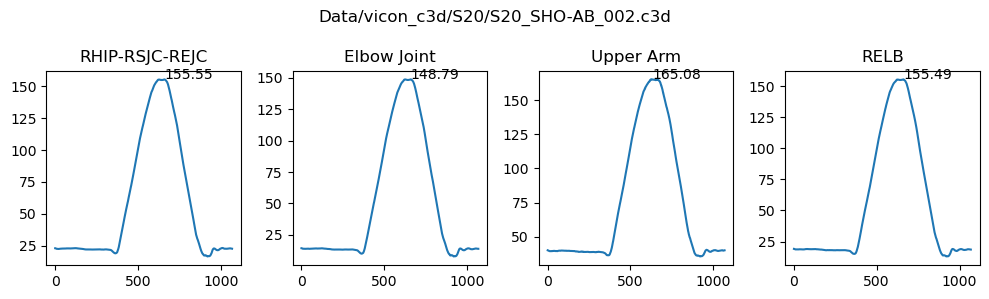

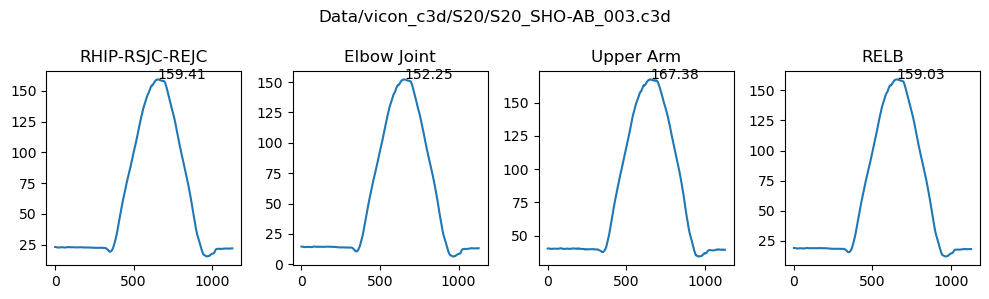

In [11]:
max_angle = []
max_angle1 = [] 
max_angle2 = []
max_angle3 = []
for file in AB_list:
    c3d = ezc3d.c3d(file,extract_forceplat_data=True)
    markers = {}
    N = len(c3d['parameters']['POINT']['LABELS']['value'])

    for i in range(N):
        markers[c3d['parameters']['POINT']['LABELS']['value'][i]] = c3d['data']['points'][:3,i,:]

    markers['PELVIS'] = (markers['RHJC']+markers['LHJC'])/2
    markers['Dist'] = (markers['CLAV']+markers['C7'])/2
    markers['Prox'] = (markers['STRN']+markers['T10'])/2
    
    marker_df = pd.DataFrame()
    marker = {}

    for c in ['RHJC','RSJC','REJC','RUPA','RSHO','Dist','Prox','LHJC','LSJC','LUPA','LEJC','LSHO','PELVIS','RELB']:
        marker[c] = markers[c]
        mkr = pd.DataFrame(markers[c])
        marker_df= pd.concat([marker_df,mkr])
        
    RHIP = marker['RHJC'][[0,2],:]
    RSJC = marker['RSJC'][[0,2],:]
    REJC = marker['REJC'][[0,2],:]
    RUPA = marker['RUPA'][[0,2],:]
    THO_PROX = marker['Prox'][[0,2], :]
    THO_DIST = marker['Dist'][[0,2], :]
    RELB = marker['RELB'][[0,2],:]
    line = RHIP - RSJC
    line1 = THO_PROX - THO_DIST
    line2 = REJC - RSJC
    line3 = RUPA - RSJC
    line4 = RELB - RSJC
    
    # 두 벡터 사이의 각도 계산
    N = line1.shape[-1]
    angles = np.zeros(N)
    angles1 = np.zeros(N)
    angles2 = np.zeros(N)
    angles3 = np.zeros(N)
    for i in range(N):
        angles[i] = calculate_angle_between_vectors(line[:,i], line2[:,i])
        angles1[i] = calculate_angle_between_vectors(line1[:,i], line2[:,i])
        angles2[i] = calculate_angle_between_vectors(line1[:,i], line3[:,i])
        angles3[i] = calculate_angle_between_vectors(line1[:,i], line4[:,i])
        
    fig, ax = plt.subplots(1,4, figsize=(10,3))
    max_angle.append(np.nanmax(angles))
    max_angle1.append(np.nanmax(angles1))
    max_angle2.append(np.nanmax(angles2))
    max_angle3.append(np.nanmax(angles3))
    
    ax[0].plot(angles)
    ax[0].text(x=np.where(angles == np.nanmax(angles))[0][0], y = np.nanmax(angles), s = round(np.nanmax(angles),2))
    ax[0].set_title('RHIP-RSJC-REJC')
    ax[1].plot(angles1)
    ax[1].text(x=np.where(angles1 == np.nanmax(angles1))[0][0], y = np.nanmax(angles1), s = round(np.nanmax(angles1),2))
    ax[1].set_title('Elbow Joint')
    ax[2].plot(angles2)
    ax[2].text(x=np.where(angles2 == np.nanmax(angles2))[0][0], y = np.nanmax(angles2), s = round(np.nanmax(angles2),2))
    ax[2].set_title('Upper Arm')
    ax[3].plot(angles3)
    ax[3].text(x=np.where(angles3 == np.nanmax(angles3))[0][0], y = np.nanmax(angles3), s = round(np.nanmax(angles3),2))
    ax[3].set_title('RELB')
    plt.suptitle(file)
    plt.tight_layout()
    plt.show()
    
    connections = [
    ('RHJC', 'RSJC'),('RSJC','RUPA'),('REJC','RUPA'),('REJC','RSJC'),
    ('LHJC', 'LSJC'),('LSJC','LUPA'),('LEJC','LUPA'),('LEJC','LSJC'),
    ('RHJC','LHJC'),('RSJC','RELB'),
    ('Prox','Dist'),
    # ('T10','C7'),
    # ('T10','STRN'),('T10','CLAV'), ('C7','STRN'),('CLAV','C7'),
]
    anim = Animated.Animate_3d(marker,speed,270,axis,file,60,connections)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    anim.save("Videos/sample.mp4", fps=30)
    plt.close()

In [12]:
print(f"RHJC-RSJC-REJC    : {np.mean(max_angle):.2f} ± {np.std(max_angle):.2f}")
print(f"Elbow joint       : {np.mean(max_angle1):.2f} ± {np.std(max_angle1):.2f}")
print(f"Upper Arm Marker  : {np.mean(max_angle2):.2f} ± {np.std(max_angle2):.2f}")
print(f"Elbow Marker      : {np.mean(max_angle3):.2f} ± {np.std(max_angle3):.2f}")

RHJC-RSJC-REJC    : 157.67 ± 1.22
Elbow joint       : 150.51 ± 1.05
Upper Arm Marker  : 160.86 ± 5.78
Elbow Marker      : 155.53 ± 2.15
